In [1]:
import sys
sys.path.append('../helper/')

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import random

import helper_functions as hpfn


# Notes

Need to run `mat_file_resave.m`, `select_natural_scenes.py`, `get_train_test_data.py` and `get_train_test_data_all_in_one.py` first.

In [2]:
# specify the folder where the data are saved
data_folder = '/mnt/d/data/'
folder_nat = data_folder + 'panoramic/data_natural_only/'
folder_nat_filtered = data_folder + 'panoramic/data_natural_only_filtered/'

## Test of the generated data

In [3]:
# check the processed data
folder_processed = data_folder + 'panoramic/processed_data_object_scal100/'
for i in os.listdir(folder_processed):
    print(i)

train_test_wide_field
vel_array_list.npy
vel_array_list_object.npy
whole_frame
whole_frame_normalized_test
whole_frame_normalized_train
whole_frame_reversed
y_test_all.npy
y_test_all_object.npy
y_train_all.npy
y_train_all_object.npy


In [4]:
y_test_all = np.load(folder_processed + 'y_test_all.npy')
y_test_all_object = np.load(folder_processed + 'y_test_all_object.npy')

print(y_test_all.shape)
print(y_test_all_object.shape)

y_train_all = np.load(folder_processed + 'y_train_all.npy')
y_train_all_object = np.load(folder_processed + 'y_train_all_object.npy')

print(y_train_all.shape)
print(y_train_all_object.shape)

(24400,)
(24400,)
(72000,)
(72000,)


In [5]:
ind = 0
X_train = np.load(folder_processed + f'whole_frame_normalized_train/X_train_{ind}.npy')
X_train_object = np.load(folder_processed + f'whole_frame_normalized_train/X_train_object_{ind}.npy')

print(X_train.shape)
print(X_train_object.shape)

(30, 20, 72)
(30, 1, 72)


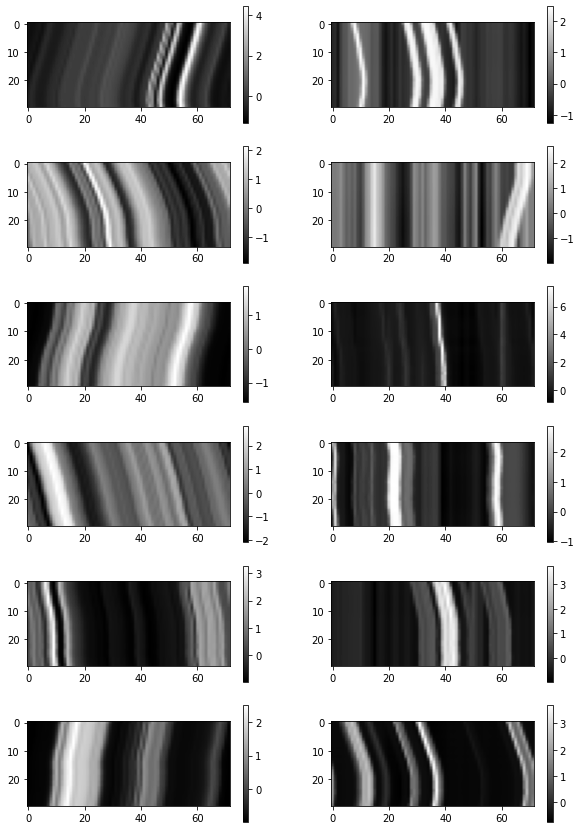

In [6]:
fig = plt.figure(figsize=(10, 15))
gs = GridSpec(6, 2, figure=fig)

for ind1 in range(6):
    for ind2 in range(2):
        ax = fig.add_subplot(gs[ind1, ind2])
        if ind2 == 0:
            ind = np.random.randint(0, 72000)
            X_train = np.load(folder_processed + f'whole_frame_normalized_train/X_train_{ind}.npy')
            h = ax.imshow(X_train[:, 10, :], 'gray')
            plt.colorbar(h)
            
        else:
            ind = np.random.randint(0, 72000)
            X_train_object = np.load(folder_processed + f'whole_frame_normalized_train/X_train_object_{ind}.npy')
            h = ax.imshow(X_train_object.squeeze(), 'gray')
            plt.colorbar(h)
plt.show()

fig.savefig(f'../results/self_vs_object_motion.png', bbox_inches='tight')

## Illustration of samples

The shape of the image is (251, 927).
Degrees per pixel in the horizontal dimension is 0.3883495145631068.


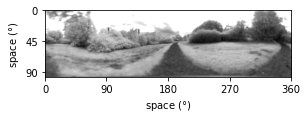

In [7]:
# Show an example of the image
ii = 3
nat_numbers = np.load(data_folder + 'panoramic/natural_scenes_numbers.npy')
img = np.load(folder_nat + f'natural_{nat_numbers[ii]}.npy')
min_val = img.min()
max_val = img.max()
K_row = img.shape[0] 
K_col = img.shape[1] 
print(f'The shape of the image is {img.shape}.')
print(f'Degrees per pixel in the horizontal dimension is {360/img.shape[1]}.')

pix_per_deg = K_col / 360
FWHM = 5 # in degree
sigma_for_gaussian = np.round(FWHM/(2*np.sqrt(2*np.log(2)))*pix_per_deg, 1) # smoothing gaussian
pad_size = int(4*sigma_for_gaussian) # this comes from the fact that the gaussian is truncated at 4*std
img_filtered = hpfn.get_filtered_spacial(img, pad_size, sigma_for_gaussian)

fig = plt.figure(figsize=(6, 1.5), constrained_layout=True)
gs = GridSpec(1, 1, figure=fig)
ax = fig.add_subplot(gs[0, 0])
ax.imshow(img, 'gray')
ax.set_xlabel(r'space ($\degree$)')
ax.set_ylabel(r'space ($\degree$)')
ax.set_xticks([0, int(K_col/4), int(K_col/2), int(K_col*3/4), K_col])
ax.set_xticklabels([0, 90, 180, 270, 360])
K_row_tem = int(90 / 97.5 * K_row)
ax.set_yticks([0, int(K_row_tem/2), K_row_tem])
ax.set_yticklabels([0, 45, 90])

fig.savefig('../results/natural_scene_img.pdf', bbox_inches='tight')

plt.show()

The shape of the velocity array is (29,).
The shape of the img processed is (30, 20, 72).
The shape of the img standardized is (30, 20, 72).


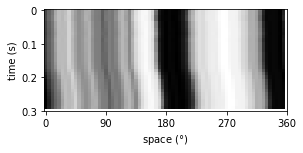

In [8]:
#############################
####### Self rotation #######
#############################

####### Generate a list of velocities #######
gamma1 = np.log(2.) / 0.2 # half-life is 10000 second, this is to generate a roughly constant speed rotation.
delta_t = 0.01 # simulation step is 0.01 second
acc_length = 100 # length of the acceleration array
vel_length = 29 # length of the velocity array
scal = 200 # one standard deviation for the velocity, in degree/s
acc_mean = 0 # mean of the acceleration, in degree/s^2
acc_std = scal * np.sqrt(2 * gamma1 / (1 - np.exp(-2 * gamma1 * acc_length * delta_t)) / delta_t) # standard deviation of the acceleration, in degree/s^2
N_vel = 1 # total different velocities

acc_array = np.random.normal(acc_mean, acc_std, acc_length)
initial_val = np.random.normal(0, scal)
vel_array = hpfn.get_filtered_OU_1d(gamma1, delta_t, acc_array, vel_length, initial_val)
print(f'The shape of the velocity array is {vel_array.shape}.')

####### Subsample the image and generate the movie #######
_, shift_array_pix = hpfn.get_shift_array(vel_array, delta_t, img)
img_processed = []
for shift in shift_array_pix:
    img_roll = np.roll(img_filtered, shift, axis=1)
    img_resized = hpfn.get_resized(img_roll)
    img_processed.append(img_resized)
img_processed = np.array(img_processed)
img_standardized = hpfn.get_standardized_row(img_processed)
print(f'The shape of the img processed is {img_processed.shape}.')
print(f'The shape of the img standardized is {img_standardized.shape}.')
        
fig = plt.figure(figsize=(6, 1.97), constrained_layout=True)
gs = GridSpec(1, 1, figure=fig)
ax = fig.add_subplot(gs[0, 0])
ax.imshow(img_standardized[:, 15, :].squeeze(), 'gray')
ax.set_xlabel(r'space ($\degree$)')
ax.set_ylabel(r'time (s)')
ax.set_xticks([0, 18, 36, 54, 72])
ax.set_yticks([0, 10, 20, 30])
ax.set_xticklabels([0, 90, 180, 270, 360])
ax.set_yticklabels([0, 0.1, 0.2, 0.3])

fig.savefig('../results/natural_scene_movie.pdf', bbox_inches='tight')
plt.show() 

The shape of the velocity array is (29,).
The shape of the img object is (30, 251, 927).
The shape of the img processed is (30, 20, 72).
The shape of the img standardized is (30, 20, 72).
The shape of the img processed is (30, 1, 72).
The shape of the img standardized is (30, 1, 72).
15


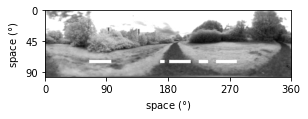

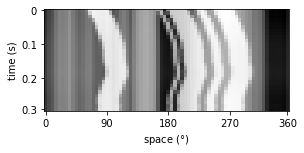

In [9]:
#############################
####### Object motion #######
#############################

####### Generate a list of velocities #######
gamma1 = np.log(2.) / 0.2 # half-life is 10000 second, this is to generate a roughly constant speed rotation.
delta_t = 0.01 # simulation step is 0.01 second
acc_length = 28 # length of the acceleration array
vel_length = 29 # length of the velocity array
scal = 200 # one standard deviation for the velocity, in degree/s
acc_mean = 0 # mean of the acceleration, in degree/s^2
acc_std = scal * np.sqrt(2 * gamma1 / (1 - np.exp(-2 * gamma1 * acc_length * delta_t)) / delta_t) # standard deviation of the acceleration, in degree/s^2
N_vel = 1 # total different velocities
N_max = 10 # upper limit of the number of moving objects

pix_per_deg = K_col / 360
FWHM = 5 # in degree
sigma_for_gaussian = np.round(FWHM/(2*np.sqrt(2*np.log(2)))*pix_per_deg, 1) # smoothing gaussian
pad_size = int(4*sigma_for_gaussian) # this comes from the fact that the gaussian is truncated at 4*std

acc_array = np.random.normal(acc_mean, acc_std, acc_length)
initial_val = scal
vel_array = hpfn.get_filtered_OU_1d(gamma1, delta_t, acc_array, vel_length, initial_val)
print(f'The shape of the velocity array is {vel_array.shape}.')

####### Subsample the image and generate the movie #######

N = 5
Ls = 5 + 31 * np.random.random(N) # angular spans of the objects, in degree
X0s = 360 * np.random.random(N) # initial positions of the objects, in degree (leftmost (rightmost) edge is 0 (360).).

row = 15
row_raw = int(np.floor(row*12.5)) # 12.5 ~ 251 / 20, where 251 is the first dimension of the image
row_patch = np.random.randint(0, 20)
while row_patch == row:
    row_patch = np.random.randint(0, 20)
row_patch_raw = int(np.floor(row_patch*12.5)) # 12.5 ~ 251 / 20, where 251 is the first dimension of the image

# Get the image patches as the objects
image_patches = []
L1 = img.shape[0]
L2 = img.shape[1]
xl = 0
for n in range(N):
    l = Ls[n]
    xr = int(np.floor(l / 360 * L2))
    yu_patch = row_patch
    yd_patch = row_patch + int(np.floor(5 / 97 * L1))
    shift = np.random.randint(0, L2)
    image_patch = np.roll(img, shift, axis=1)[yu_patch:yd_patch, :xr]
    image_patches.append(image_patch)

shift_array_deg, _ = hpfn.get_shift_array(vel_array, delta_t, img)
img_object = []
img_processed = []
img_processed_row = []
for shift in shift_array_deg:
    img_array = img.copy()
    mask_in_x_union = np.zeros(img_array.shape[1])
    for n in range(N):
        x = X0s[n]
        l = Ls[n]
        img_array, mask_in_x = hpfn.add_object_to_image_periodic_boundary(img_array, x+shift, l, row_raw, image_patches[n])
        mask_in_x_union = mask_in_x_union + mask_in_x
    mask_in_x_union[mask_in_x_union!=0] = 1
    img_object.append(img_array)
    img_array = hpfn.get_filtered_spacial(img_array, pad_size, sigma_for_gaussian)
    img_resized = hpfn.get_resized(img_array)
    img_processed.append(img_resized)
    img_processed_row.append(img_resized[row:row+1, :])
img_object = np.array(img_object)
img_processed = np.array(img_processed)
img_processed_row = np.array(img_processed_row)
img_standardized = hpfn.get_standardized_row(img_processed)
img_standardized_row = hpfn.get_standardized_row(img_processed_row)
print(f'The shape of the img object is {img_object.shape}.')
print(f'The shape of the img processed is {img_processed.shape}.')
print(f'The shape of the img standardized is {img_standardized.shape}.')
print(f'The shape of the img processed is {img_processed_row.shape}.')
print(f'The shape of the img standardized is {img_standardized_row.shape}.')
print(row)

fig = plt.figure(figsize=(6, 1.5), constrained_layout=True)
gs = GridSpec(1, 1, figure=fig)
ax = fig.add_subplot(gs[0, 0])
ax.imshow(img_object[0], 'gray')
ax.set_xlabel(r'space ($\degree$)')
ax.set_ylabel(r'space ($\degree$)')
ax.set_xticks([0, int(K_col/4), int(K_col/2), int(K_col*3/4), K_col])
ax.set_xticklabels([0, 90, 180, 270, 360])
K_row_tem = int(90 / 97.5 * K_row)
ax.set_yticks([0, int(K_row_tem/2), K_row_tem])
ax.set_yticklabels([0, 45, 90])

fig.savefig('../results/natural_scene_object_img.pdf', bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(6, 1.97), constrained_layout=True)
gs = GridSpec(1, 1, figure=fig)
ax = fig.add_subplot(gs[0, 0])
ax.imshow(img_standardized_row.squeeze(), 'gray')
ax.set_xlabel(r'space ($\degree$)')
ax.set_ylabel(r'time (s)')
ax.set_xticks([0, 18, 36, 54, 71])
ax.set_yticks([0, 10, 20, 29])
ax.set_xticklabels([0, 90, 180, 270, 360])
ax.set_yticklabels([0, 0.1, 0.2, 0.3])

fig.savefig('../results/natural_scene_object_movie.pdf', bbox_inches='tight')
plt.show()  
    
    
